# Capstone Project
## Probabilistic generative models
### Instructions

In this notebook, you will practice working with generative models, using both normalising flow networks and the variational autoencoder algorithm. You will create a synthetic dataset with a normalising flow with randomised parameters. This dataset will then be used to train a variational autoencoder, and you will used the trained model to interpolate between the generated images. You will use concepts from throughout this course, including Distribution objects, probabilistic layers, bijectors, ELBO optimisation and KL divergence regularisers.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports below. For this project you are free to make further imports throughout the notebook as you wish. 

In [28]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, you will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$. 
* You should use or construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution. 
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$ and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

In [2]:
class F_3(tfb.Bijector):
  def __init__(self, a, validate_args=False):
    super(F_3, self).__init__(validate_args=validate_args, forward_min_event_ndims=1)
    self.a = a
  
  def _forward(self, x):
    return tf.concat([tf.expand_dims(x[..., 0], axis=-1), tf.expand_dims(x[..., 1] + self.a * x[..., 0]**2, axis=-1)], axis=-1)
  
  def _inverse(self, y):
    return tf.concat([tf.expand_dims(y[..., 0], axis=-1), tf.expand_dims(y[..., 1] - self.a * y[..., 0]**2, axis=-1)], axis=-1)

  def _inverse_log_det_jacobian(self, y):
    return tf.cast(0, tf.float32)
  
  def _forward_log_det_jacobian(self, x):
    return -self._inverse_log_det_jacobian(self.forward(x))

In [3]:
def get_transformed_dist():
  sig = 0.3
  z = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[sig, sig])

  a_dist = tfd.Normal(3, 1)
  theta_dist = tfd.Uniform(low=0, high=2*np.pi)

  a = a_dist.sample()
  theta = theta_dist.sample()

  f_1 = tfb.Shift(shift=[0., -2.])
  f_2 = tfb.Scale(scale=[1., 0.5])
  f_3 = F_3(a)

  R = [[tf.math.cos(theta), -tf.math.sin(theta)],
      [tf.math.sin(theta), tf.math.cos(theta)]]
  rotate = tf.linalg.LinearOperatorFullMatrix(R)
  f_4 = tfb.ScaleMatvecLinearOperator(rotate)

  f_5 = tfb.Tanh()

  chained_bijector = tfb.Chain([f_5, f_4, f_3, f_2, f_1])
  transformed_dist = tfd.TransformedDistribution(z, chained_bijector)
  
  return z, transformed_dist

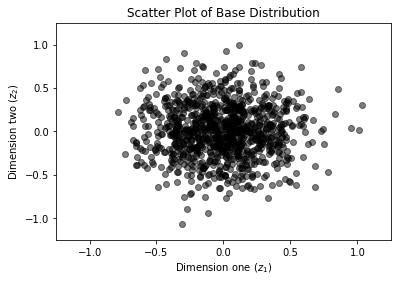

In [4]:
z, transformed_dist = get_transformed_dist()

samples = z.sample(1000)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, color='k')
plt.xlabel('Dimension one ($z_1$)')
plt.ylabel('Dimension two ($z_2$)')
plt.title('Scatter Plot of Base Distribution')
plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.show()

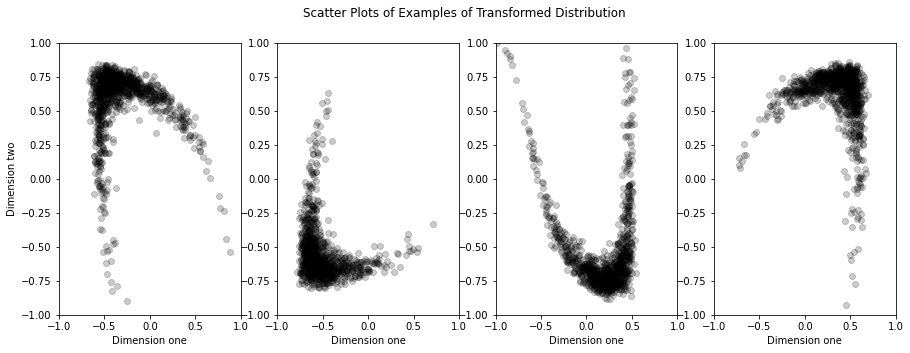

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15,5))
fig.suptitle('Scatter Plots of Examples of Transformed Distribution')

for i in range(4):
  z, transformed_dist = get_transformed_dist()
  samples = transformed_dist.sample(1000)
  axs[i].scatter(samples[:, 0], samples[:, 1], alpha=0.2, color='k')
  axs[i].set_xlim([-1, 1])
  axs[i].set_ylim([-1, 1])
  axs[i].set_xlabel('Dimension one')
  if i == 0:
    axs[i].set_ylabel('Dimension two')

## 2. Create the image dataset
* You should now use your random normalising flow to generate an image dataset of contour plots from your random normalising flow network. 
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters. 
  * You may find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot. 
* Your dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help you to generate the dataset. 
  * This function creates a numpy array for an image of the contour plot for a given set of density values Z. Feel free to choose your own options for the contour plots.
* Display a sample of 20 images from your generated dataset in a figure.

In [6]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    #Z = transformed_distribution.prob(tf.cast(tf.expand_dims(inputs, 2), tf.float32))
    Z = transformed_distribution.prob(tf.cast(inputs, tf.float32))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [7]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='prism', levels=40)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

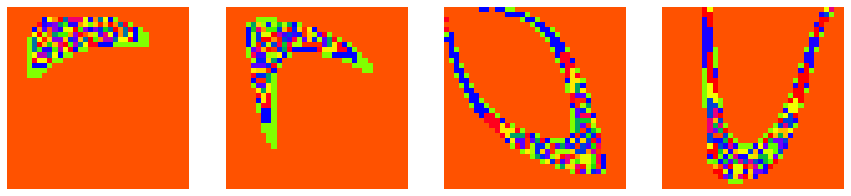

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15,5))

for i in range(4):
  z, transformed_dist = get_transformed_dist()
  Z = get_densities(transformed_dist)
  image_from_plot = get_image_array_from_density_values(Z)
  axs[i].imshow(image_from_plot)
  axs[i].axis('off')

In [9]:
n_images = 1000

dataset = np.zeros(shape=(n_images, 36, 36, 3))

flag = 0
for i in range(n_images):
  if i % 100 == 0:
    print('{}% finished'.format(flag))
    flag +=10
  z, transformed_dist = get_transformed_dist()
  Z = get_densities(transformed_dist)
  image_from_plot = get_image_array_from_density_values(Z)
  dataset[i, ...] = image_from_plot
print('finished')

0% finished
10% finished
20% finished
30% finished
40% finished
50% finished
60% finished
70% finished
80% finished
90% finished


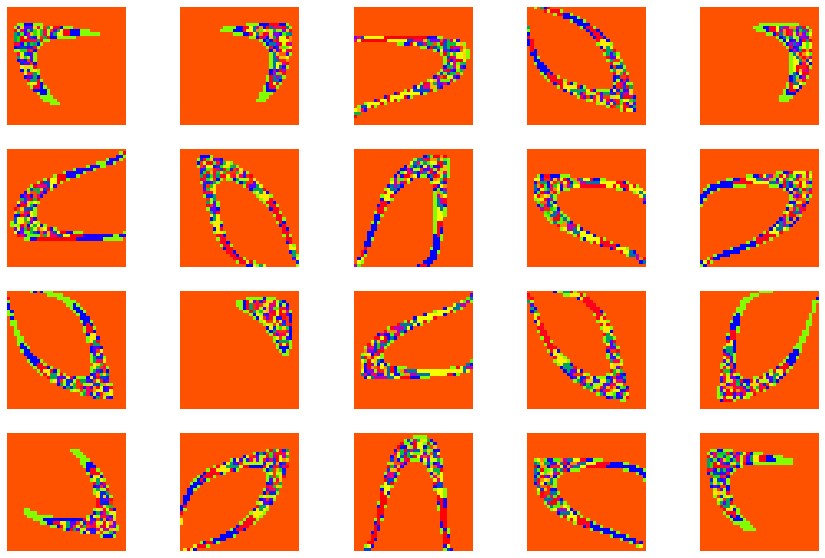

In [10]:
idx = np.random.choice(np.arange(n_images), size=20, replace=False)

fig, axs = plt.subplots(4, 5, figsize=(15,10))

flag = 0
for i in range(4):
  for j in range(5):
    img = dataset[idx[flag], ...]
    axs[i, j].imshow(img.astype('int'))
    axs[i, j].axis('off')
    flag += 1

## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [11]:
data_train = tf.data.Dataset.from_tensor_slices(dataset[:800, ...])
data_test = tf.data.Dataset.from_tensor_slices(dataset[800:, ...])

In [12]:
def rescale(image):
  return image / 255.

data_train = data_train.map(rescale)
data_test = data_test.map(rescale)

In [13]:
def input_output(image):
  return image, image

data_train = data_train.map(input_output)
data_test = data_test.map(input_output)

In [14]:
data_train = data_train.shuffle(100)

In [15]:
data_train = data_train.batch(20, drop_remainder=True)
data_test = data_test.batch(20, drop_remainder=True)

In [16]:
print(data_train.element_spec)
print(data_test.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None))
(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None))


## 4. Build the encoder and decoder networks
* You should now create the encoder and decoder for the variational autoencoder algorithm.
* You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.
* Print the model summary for the encoder and decoder networks.

In [31]:
latent_size = 7
event_shape = (36, 36, 3)
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

encoder = Sequential([
                      Conv2D(21, 5, strides=2, activation='tanh', input_shape=event_shape),
                      BatchNormalization(),
                      Conv2D(21, 5, strides=2, activation='tanh'),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='tanh'),
                      BatchNormalization(),
                      Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
                      tfpl.MultivariateNormalTriL(latent_size), 
                      tfpl.KLDivergenceAddLoss(prior)
], name='encoder')

decoder = Sequential([
                      Dense(72, activation='tanh', input_shape=(latent_size,)),
                      BatchNormalization(),
                      Dense(144, activation='tanh'),
                      BatchNormalization(),
                      Dense(288, activation='tanh'),
                      BatchNormalization(),
                      Reshape((6,6,8)),
                      Conv2DTranspose(8, 5, strides=2, output_padding=1, activation='tanh'),
                      BatchNormalization(),
                      Conv2DTranspose(8, 5, strides=2, output_padding=1, activation='tanh'),
                      BatchNormalization(),
                      Conv2D(3, 3, padding='same'),
                      Flatten(),
                      tfpl.IndependentBernoulli(event_shape)
], name='decoder')

In [32]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 21)        1596      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 21)        84        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 21)          11046     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 21)          84        
_________________________________________________________________
flatten_2 (Flatten)          (None, 756)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                48448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256 

In [33]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 72)                576       
_________________________________________________________________
batch_normalization_3 (Batch (None, 72)                288       
_________________________________________________________________
dense_8 (Dense)              (None, 144)               10512     
_________________________________________________________________
batch_normalization_4 (Batch (None, 144)               576       
_________________________________________________________________
dense_9 (Dense)              (None, 288)               41760     
_________________________________________________________________
batch_normalization_5 (Batch (None, 288)               1152      
_________________________________________________________________
reshape_1 (Reshape)          (None, 6, 6, 8)           0   

## 5. Train the variational autoencoder
* You should now train the variational autoencoder. Build the VAE using the `Model` class and the encoder and decoder models. Print the model summary.
* Compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation Datasets.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [34]:
vae = Model(inputs=encoder.input, outputs=decoder(encoder.output))
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 36, 36, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 21)        1596      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 21)        84        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 21)          11046     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 21)          84        
_________________________________________________________________
flatten_2 (Flatten)          (None, 756)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                48448 

In [35]:
vae.compile(loss=lambda x, pred: -pred.log_prob(x))

In [36]:
history = vae.fit(data_train, epochs=20, validation_data=data_test)

Epoch 1/20
40/40 [==============================] - 6s 72ms/step - loss: 2705.6218 - val_loss: 2355.6340
Epoch 2/20
40/40 [==============================] - 2s 60ms/step - loss: 2207.3040 - val_loss: 1934.9591
Epoch 3/20
40/40 [==============================] - 2s 61ms/step - loss: 1806.6567 - val_loss: 1624.4938
Epoch 4/20
40/40 [==============================] - 2s 60ms/step - loss: 1547.0280 - val_loss: 1463.6211
Epoch 5/20
40/40 [==============================] - 2s 61ms/step - loss: 1421.1211 - val_loss: 1427.6626
Epoch 6/20
40/40 [==============================] - 2s 61ms/step - loss: 1379.0461 - val_loss: 1392.1698
Epoch 7/20
40/40 [==============================] - 2s 61ms/step - loss: 1363.8832 - val_loss: 1371.5084
Epoch 8/20
40/40 [==============================] - 3s 62ms/step - loss: 1350.5977 - val_loss: 1339.4163
Epoch 9/20
40/40 [==============================] - 3s 62ms/step - loss: 1346.0928 - val_loss: 1324.7719
Epoch 10/20
40/40 [==============================] - 2s

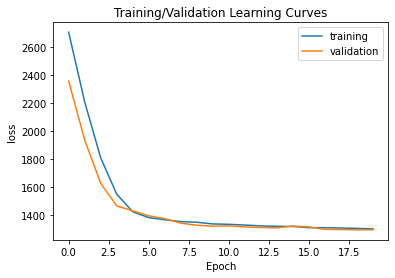

In [40]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training/Validation Learning Curves')
plt.show()

## 6. Use the encoder and decoder networks
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

In [57]:
dataset_rescale = dataset / 255.

In [58]:
latent_samples = encoder(dataset_rescale).sample()
latent_samples.shape

TensorShape([1000, 7])

In [59]:
from sklearn.decomposition import PCA

latent_samples_dim2 = PCA(n_components=2).fit_transform(latent_samples)
latent_samples_dim2.shape

(1000, 2)

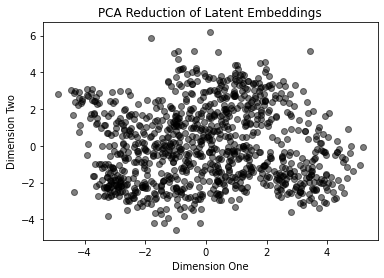

In [60]:
plt.scatter(latent_samples_dim2[:,0], latent_samples_dim2[:,1], color='k', alpha=0.5)
plt.xlabel('Dimension One')
plt.ylabel('Dimension Two')
plt.title('PCA Reduction of Latent Embeddings')
plt.show()

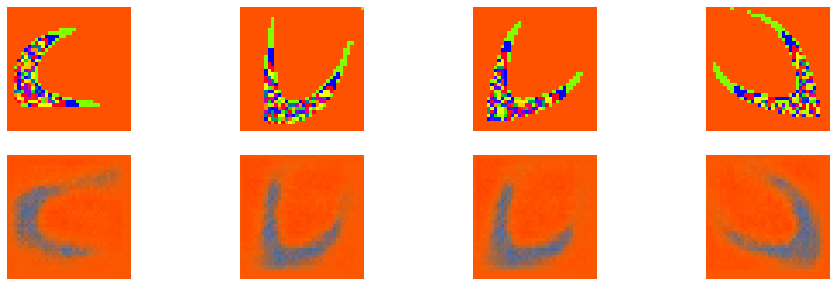

In [77]:
idx = np.random.choice(np.arange(n_images), size=4, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(16,5))

for i in range(4):
  example_reconstruction = vae(dataset_rescale[idx[i], ...][np.newaxis, ...]).mean().numpy().squeeze()
  axs[0, i].imshow(dataset_rescale[idx[i], ...], cmap='prism')
  axs[1, i].imshow(example_reconstruction, cmap='prism')
  axs[0, i].axis('off')
  axs[1, i].axis('off')

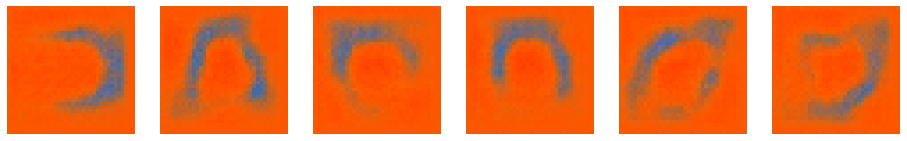

In [83]:
fig, axs = plt.subplots(1, 6, figsize=(16,5))

for i in range(6):
  prior_sample = tf.expand_dims(prior.sample(), axis=0)
  reconstruction_example = decoder(prior_sample).mean().numpy().squeeze()
  axs[i].imshow(reconstruction_example)
  axs[i].axis('off')